<a href="https://colab.research.google.com/github/phytometrics/plant_phenotyping_python/blob/dev/notebooks/pollencounter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ブドウ花粉生存率評価
<img width=50% src="https://github.com/phytometrics/plant_phenotyping_python/blob/main/notebooks/imgs/13007_2017_267_MOESM5_ESM.jpg?raw=true">

ぶどう花粉染色図。RGB画像とR,G,Bそれぞれのチャンネルでの輝度。 Tello et al., 2018, Plant Methods

## ライセンス
- Tello, J., Montemayor, M. I., Forneck, A., & Ibáñez, J. (2018). A new image-based tool for the high throughput phenotyping of pollen viability: evaluation of inter- and intra-cultivar diversity in grapevine. Plant Methods, 14, 3. https://doi.org/10.1186/s13007-017-0267-2
    - CC-BY 4.0
- 本ノートブック
    - CC-BY-NC4.0

## 解説
花粉の活性度（Viability）は農業形質上重要な尺度となります。花粉の活性度、特にぶどうのそれは最終的な収量に加え、着果率や受粉率を始めとして多くの形質に影響を与えることが知られています。花粉の生存率を簡便に調べるため、筆者らはPollenCounterと呼ばれるImageJのマクロを開発しました。PollenCounterがどのような画像処理をしているか、 論文のAdditional File 2に記載のコードから該当箇所を抜粋し、解説を付け加えました。

```java
1. run("Subtract Background...", "rolling=50 light");
    // RGB型式の入力画像から、背景情報（照明の不均一性やノイズなど）を除去します。
2. run("Split Channels");
    // 画像をRチャンネル,Gチャンネル,Bチャンネルそれぞれ単一の3つのグレースケール画像に分割します。
3-1. //red channelに対して以下の処理を適用する
    - setAutoThreshold("Default");
        // 画像をもとにグローバル閾値を自動で求め、二値化によるバイナリー画像を作成します。
    - run("Dilate");　　 // with iteration 5
    - run("Fill Holes");  // with iteration 5
    - run("Erode");  // with iteration 5
        // dilate処理、穴埋め、erode処理で検出領域の穴などを塞ぎます。
    - run("Watershed");  
        // Watershedアルゴリズムで隣接する花粉などを分割します。
    - run("Analyze Particles...", "size=60-800 circularity=0.40-1.00 ..省略");
        //粒子（花粉）の形状や数を計測します。オブジェクト候補のうち、面積が60-800pxのレンジにはいり、かつ真円度が0.4-1.0のもののみを解析対象にします。
3-2. //green channelに対して以下の処理を適用する
    - run("Dilate");  // with iteration 5
    - run("Fill Holes");  // with iteration 5
    - run("Erode");  // with iteration 5
    - run("Watershed");
    - run("Analyze Particles...", "size=100-800 circularity=0.40-1.00 ...省略");
        // 同様に粒子（花粉）の形状や数を計測しますが、サイズの閾値がr-channelのそれと異なることに注意。

```
上述のpseudoコードによって得られた結果をもとに、生存率APVを計算します。

- Automatic Pollen Viability (APV, 自動測定花粉生存率)

    - Pollen Grains<sub>G</sub>とPollen Grains<sub>G</sub>は、それぞれGチャンネルとRチャンネルで計測された花粉の数になります。

$$
APV_{\text{img}}(\%) = \frac{Pollen Grains_G}{All Polen Grains_R} \times 100 \
$$

## 注意

大部分がpythonでも容易に再現可能なため、PollenCounterをPythonで再実装します。しかしながらImageJとpythonで使用可能な画像処理ライブラリ（scikit-imageなど）では同様の画像処理操作の関数であってもハイパーパラメーターを含む実装が異なることにより、同様の結果を保障するものではありません。あくまでアルゴリズム実装の参考として本ノートブックを使用してください。

## 実行コード

In [2]:
!wget -O pollen.zip https://static-content.springer.com/esm/art%3A10.1186%2Fs13007-017-0267-2/MediaObjects/13007_2017_267_MOESM3_ESM.zip
!unzip pollen.zip

--2024-01-03 12:46:05--  https://static-content.springer.com/esm/art%3A10.1186%2Fs13007-017-0267-2/MediaObjects/13007_2017_267_MOESM3_ESM.zip
Resolving static-content.springer.com (static-content.springer.com)... 151.101.0.95, 151.101.64.95, 151.101.128.95, ...
Connecting to static-content.springer.com (static-content.springer.com)|151.101.0.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8438305 (8.0M) [application/zip]
Saving to: ‘pollen.zip’

pollen.zip          100%[===================>]   8.05M  --.-KB/s    in 0.1s    

2024-01-03 12:46:07 (81.9 MB/s) - ‘pollen.zip’ saved [8438305/8438305]

Archive:  pollen.zip
replace AddFile3/Vv_Pollen_Alcanon.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: AddFile3/Vv_Pollen_Alcanon.JPG  
  inflating: AddFile3/Vv_Pollen_Aligote.JPG  
  inflating: AddFile3/Vv_Pollen_Beba.JPG  
  inflating: AddFile3/Vv_Pollen_Cabernet_Franc.JPG  
  inflating: AddFile3/Vv_Pollen_Clairette_Blanche.JPG  
  inflating: AddFile3/V

In [25]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import ndimage as ndi
from scipy.ndimage import binary_fill_holes
from skimage.filters import threshold_isodata
from skimage.measure import label, regionprops
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.morphology import binary_dilation, binary_erosion

### Step by Step 実装

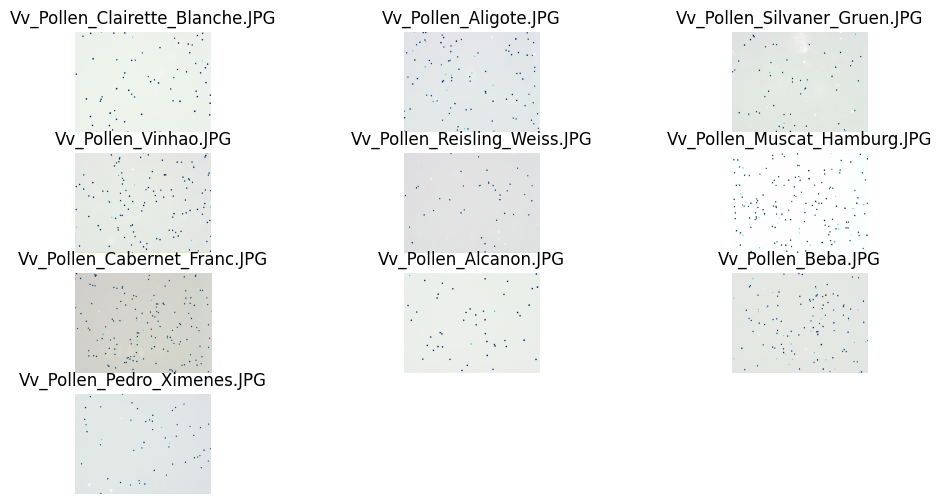

In [4]:
image_dir = "/content/AddFile3"
image_files = os.listdir(image_dir)

plt.figure(figsize=(12,6))
for i, image_file in enumerate(image_files):
    plt.subplot(4,3,i+1)

    plt.title(image_file)
    plt.axis("off")
    image = cv2.imread(os.path.join(image_dir, image_file))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)

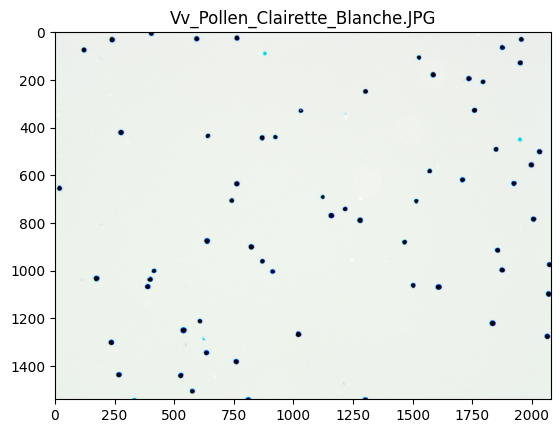

In [45]:
#　まずは単一画像について解析してみましょう。

image_file = image_files[0]

# 画像読み込み
path = os.path.join(image_dir, image_file)
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.title("original image")
plt.title(image_file)
plt.imshow(image)
plt.show()

ImageJの背景除去（subtractBackground）は、グレースケール画像だけでなくカラー画像にも適用可能です。カラー画像の場合、HSB色空間に変換した後、B(Brightness)チャンネルにRolling Ballアルゴリズムを用いて背景除去を実施します。その後、画像はRGB色空間に戻されます。

pythonでは、対応するような機能がskimageやopencvの機能として提供されておらず、自身で実装する必要があります。

下に簡易的な実装をしめします。ただし出力結果を見てわかるように、この実装では１画像の処理に１分以上かかってしまいます。目的が照明ムラの除去であること、サンプル画像の照明ムラが抑えられていることを考慮し、本稿ではこのステップを省略します。

CPU times: user 1min 37s, sys: 2.01 s, total: 1min 39s
Wall time: 1min 45s


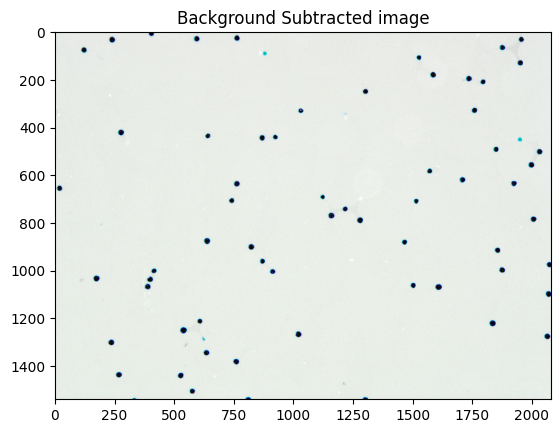

In [46]:
%%time

from skimage.color import rgb2hsv, hsv2rgb
from skimage.morphology import white_tophat, black_tophat, disk

def subtract_background(image, radius=50, background_is_white=True):
    hsb = rgb2hsv(image)  #hsvとhsbは同義
    h, s, b = hsb[...,0], hsb[...,1], hsb[...,2]

    selem = disk(radius)
    if background_is_white:
        background = black_tophat(b, selem)
    else:
        background = white_tophat(b, selem)

    b_corrected = b - background
    hsv_corrected = np.dstack((h, s, b_corrected))
    rgb_corrected = hsv2rgb(hsv_corrected)
    # 0-1から0-255の範囲の画像に戻します。
    rgb_corrected *= 255
    rgb_corrected = rgb_corrected.astype(np.uint8)
    return rgb_corrected

corrected = subtract_background(image)
plt.title("Background Subtracted image")
plt.imshow(corrected)

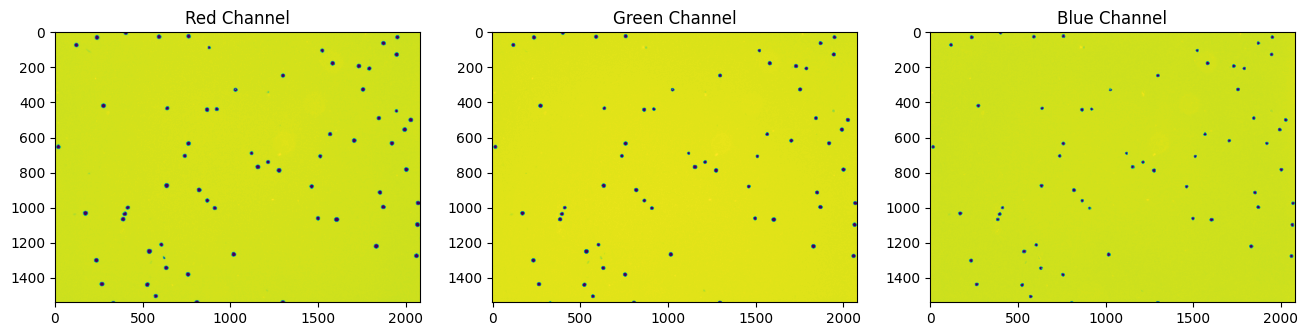

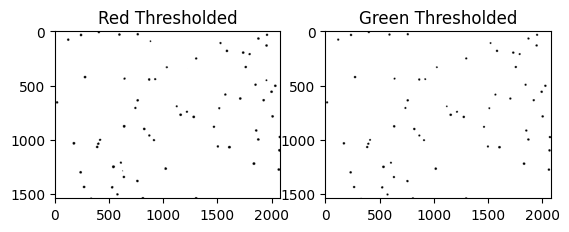

In [47]:
# RGB チャンネルの分割、それぞれのチャンネルで二値化処理。

r_channel, g_channel,  b_channel = image[...,0], image[...,1], image[...,2]
plt.figure(figsize=(16,9))
plt.subplot(1,3,1)
plt.title("Red Channel")
plt.imshow(r_channel)
plt.subplot(1,3,2)
plt.title("Green Channel")
plt.imshow(g_channel)
plt.subplot(1,3,3)
plt.title("Blue Channel")
plt.imshow(b_channel)
plt.show()
# redとgreenのみ使う
r_thresh = threshold_isodata(r_channel)
r_channel = r_channel > r_thresh

g_thresh = threshold_isodata(g_channel)
g_channel = g_channel > g_thresh

plt.subplot(1,2,1)
plt.title("Red Thresholded")
plt.imshow(r_channel, cmap="gray")
plt.subplot(1,2,2)
plt.title("Green Thresholded")
plt.imshow(g_channel, cmap="gray")
plt.show()

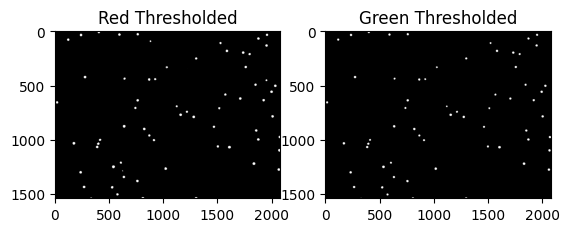

In [48]:
# pythonでは解析対象が白、背景が黒であることを前提とする解析が多いため、それにならい白黒反転させます
r_channel = np.logical_not(r_channel)
g_channel = np.logical_not(g_channel)

plt.subplot(1,2,1)
plt.title("Red Thresholded")
plt.imshow(r_channel, cmap="gray")
plt.subplot(1,2,2)
plt.title("Green Thresholded")
plt.imshow(g_channel, cmap="gray")
plt.show()

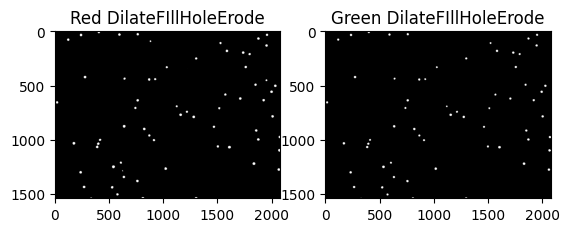

In [49]:
# dilate, erode, fill_holes処理を行います。
# なお、ImageJマクロでは白背景に対して一連の処理を行っていますが、ImageJでは背景を白色であることを明示して処理が可能です。
# 今回Pythonでは、黒色背景を前提として一連の処理を行います。

for i in range(5):
    r_channel = binary_dilation(r_channel)
    g_channel = binary_dilation(g_channel)
for i in range(5):
    r_channel = binary_fill_holes(r_channel)
    g_channel = binary_fill_holes(g_channel)
for i in range(5):
    r_channel = binary_erosion(r_channel)
    g_channel = binary_erosion(g_channel)


plt.subplot(1,2,1)
plt.title("Red DilateFIllHoleErode")
plt.imshow(r_channel, cmap="gray")
plt.subplot(1,2,2)
plt.title("Green DilateFIllHoleErode")
plt.imshow(g_channel, cmap="gray")
plt.show()


In [50]:
def watershed_segmentation(binary):
    # Compute the distance transform
    distance = ndi.distance_transform_edt(binary)
    # Identify local maxima in the distance transform as markers
    coordinates = peak_local_max(distance, min_distance=5, footprint=np.ones((3, 3)), labels=binary)
    # Create a boolean mask from the coordinates
    local_maxi = np.zeros(distance.shape, dtype=bool)
    for coord in coordinates:
        local_maxi[coord[0], coord[1]] = True
    markers = label(local_maxi)
    # Apply the watershed algorithm
    lbl_image = watershed(-distance, markers, mask=binary)
    return lbl_image


# Watershed　アルゴリズムを用い、２つ以上隣接している花粉がある場合切り離します。
r_lbl_image = watershed_segmentation(r_channel)
# ImageJのpartical analysisをscikit-imageのregionpropsの機能で代替します。
r_props = regionprops(r_lbl_image)
print("r channel object no:",len(r_props))

g_lbl_image = watershed_segmentation(g_channel)
g_props = regionprops(g_lbl_image)
print("g channel object no:",len(g_props))

r channel object no: 71
g channel object no: 64


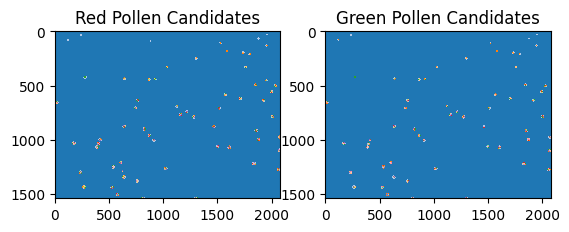

In [51]:
plt.subplot(1,2,1)
plt.title("Red Pollen Candidates")
plt.imshow(r_lbl_image, cmap="tab20")
plt.subplot(1,2,2)
plt.title("Green Pollen Candidates")
plt.imshow(g_lbl_image, cmap="tab20")
plt.show()

In [52]:
# area filtering
# area 60 - 800 px filtering in red channel
r_props = [x for x in r_props if x.area > 60 and x.area < 800]
# area 100 - 800 px filtering in green channel
g_props = [x for x in g_props if x.area > 100 and x.area < 800]

# circularityはregionpropsで算出されないので、別途計算して新しいattributeとして付加する
for prop in r_props:
    circularity = (4 * np.pi * prop.area) / (prop.perimeter ** 2)
    prop.circularity = circularity

for prop in g_props:
    circularity = (4 * np.pi * prop.area) / (prop.perimeter ** 2)
    prop.circularity = circularity

# circularity filtering keep 0.4 -1.00 for both channel
r_props = [x for x in r_props if x.circularity > 0.4 and x.circularity < 1.0]
# area 100 - 800 px filtering in green channel
g_props = [x for x in g_props if x.circularity > 0.4 and x.circularity < 1.0]

print("final r channel object no:",len(r_props))
print("final g channel object no:",len(g_props))

final r channel object no: 65
final g channel object no: 59


花粉（＝Rチャンネルでの検出数）が65個検出され、その中でも生存花粉（Gチャンネルでの検出数）は59個であることが導き出されました。100*59/65でAPVは90.8%となります。これらのコードを１つの関数としてまとめ、全ての画像に対して解析をしてみましょう。

In [53]:
def pollen_viability_analysis(path):

    def watershed_segmentation(binary):
        # Compute the distance transform
        distance = ndi.distance_transform_edt(binary)
        # Identify local maxima in the distance transform as markers
        coordinates = peak_local_max(distance, min_distance=10, footprint=np.ones((3, 3)), labels=binary)
        # Create a boolean mask from the coordinates
        local_maxi = np.zeros(distance.shape, dtype=bool)
        for coord in coordinates:
            local_maxi[coord[0], coord[1]] = True
        markers = label(local_maxi)
        # Apply the watershed algorithm
        lbl_image = watershed(-distance, markers, mask=binary)
        return lbl_image


    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # 今回は採用しない
    # image = subtract_background(image)

    r_channel, g_channel, _ = image[...,0], image[...,1], image[...,2]

    r_thresh = threshold_isodata(r_channel)
    r_channel = r_channel > r_thresh

    g_thresh = threshold_isodata(g_channel)
    g_channel = g_channel > g_thresh

    r_channel = np.logical_not(r_channel)
    g_channel = np.logical_not(g_channel)

    for i in range(5):
        r_channel = binary_dilation(r_channel)
        g_channel = binary_dilation(g_channel)
    for i in range(5):
        r_channel = binary_fill_holes(r_channel)
        g_channel = binary_fill_holes(g_channel)
    for i in range(5):
        r_channel = binary_erosion(r_channel)
        g_channel = binary_erosion(g_channel)

    r_lbl_image = watershed_segmentation(r_channel)
    r_props = regionprops(r_lbl_image)
    g_lbl_image = watershed_segmentation(g_channel)
    g_props = regionprops(g_lbl_image)

    r_props = [x for x in r_props if x.area > 60 and x.area < 800]
    g_props = [x for x in g_props if x.area > 100 and x.area < 800]

    # areaでフィルタリングした後の候補領域が残っていた場合のみ２段階目のフィルタリングをかける
    if len(r_props) !=0:
        for prop in r_props:
            circularity = (4 * np.pi * prop.area) / (prop.perimeter ** 2)
            prop.circularity = circularity
        r_props = [x for x in r_props if x.circularity > 0.4 and x.circularity < 1.0]

    if len(r_props) !=0:
        for prop in g_props:
            circularity = (4 * np.pi * prop.area) / (prop.perimeter ** 2)
            prop.circularity = circularity
        g_props = [x for x in g_props if x.circularity > 0.4 and x.circularity < 1.0]

    all_pollen = len(r_props)
    viable_pollen = len(g_props)
    apv = (viable_pollen / all_pollen) * 100
    return apv

In [54]:
image_dir = "/content/AddFile3"
image_files = os.listdir(image_dir)

results = []

for image_file in image_files:
    path = os.path.join(image_dir, image_file)
    apv = pollen_viability_analysis(path)
    results.append([image_file, apv])

df = pd.DataFrame(results, columns=["image","APV"])
df

,image,APV
0,Vv_Pollen_Clairette_Blanche.JPG,93.650794
1,Vv_Pollen_Aligote.JPG,75.824176
2,Vv_Pollen_Silvaner_Gruen.JPG,76.923077
3,Vv_Pollen_Vinhao.JPG,87.068966
4,Vv_Pollen_Reisling_Weiss.JPG,86.842105
5,Vv_Pollen_Muscat_Hamburg.JPG,83.766234
6,Vv_Pollen_Cabernet_Franc.JPG,88.970588
7,Vv_Pollen_Alcanon.JPG,93.877551
8,Vv_Pollen_Beba.JPG,75.000000
9,Vv_Pollen_Pedro_Ximenes.JPG,70.833333


## 最後に
ImageJのマクロが完成しているにも関わらず、一部の工程を省略してPythonでの実装を試みるのは、一見ナンセンスに見えるかもしれません。しかし、この取り組みはPythonを通じての画像処理の理解を深めることを目的としていること、ご理解ください。